# 基于神经网络的时间序列预测

本代码来自弗朗西斯卡所著《时间序列预测：基于机器学习和python实现》

In [22]:
import datetime as dt
import os
import warnings
from collections import UserDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 两种绘图接口
import plotly_express as px  
import plotly.graph_objects as go

%matplotlib inline

warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)

## 将深度学习用作时间序列预测的原因

深度学习神经网络具有三个主要的内在特征：
- 深度学习神经网络能够自动从原始数据中学习和提取特征。
- 深度学习支持多个输入和输出。
- 循环神经网络擅长提取跨越相对较长序列的输入数据中的模式。

神经网络消除了对特征工程过程、数据缩放过程的大量迫切需求以及通过差分是数据保持稳定。

1、单变量时间序列是具有单个时间相关变量的序列。在单变量时间序列场景中，数据集将基于两个变量，即时间和历史观测值。  
2、多变量时间序列是具有多个与时间有关的变量。这样的序列属于多元时间序列。

将深度学习用于多步预测的主要方法有两种：
- 直接：开发单独的模型来预测每个的前置时间。
- 递归：开发一个模型来进行单步预测，并循环使用该模型，其中先前的预测用作输入以预测后续的前置时间。

## 基于循环神经网络的时间序列预测

### 循环神经网络

RNN是具有隐含状态和循环的神经网络，可以使信息随时间持续存在。

![hello](../images/p14.jpg)

RNN具有一个内部隐含状态，表示为$H$，可以将其反馈给网络。在此图中，RNN处理输入值$X$并产生输出值$Y$。隐含状态（表示为$H$）允许信息从网络的一个节点转发到下一个节点（按序列或向量组织）。向量现在具有与当前输入和先前输入有关的信息，通过$tanh$激活，输出为新的隐含状态。$tanh$激活用于调节通过网络的值，并且始终将值保持在-1和1之间。

$W$表示每个单元具有三组权重，一组用于输入（$X$），一组用于上一个时间步（$H$），剩余一组用于当前时间步的输出（$Y$）。这些权重值由训练过程确定，可以通过梯度下降来实现。

我们将相同的权重应用于输入序列中的不同项目，这意味着在输入时共享参数。如果不能在输入时共享参数，那么RNN就像普通的神经网络一样，每个输入节点都需要自己的权重。相反，RNN可以利用其隐含状态属性，该属性将当前输入绑定到下一个输入，并将此输入连接合并为串行输入。

![hello](../images/p15.jpg)

RNN问题
- 如果输入序列足够长，则其无法将信息从较早的时间步传递到较晚的时间步。
- 在反向传播期间，因为随着时间反向传播，其梯度会减小。因此循环神经网络会遇到梯度消失的问题，提出LSTM，在LSTM中引入了成为门和单元状态的其他元素。

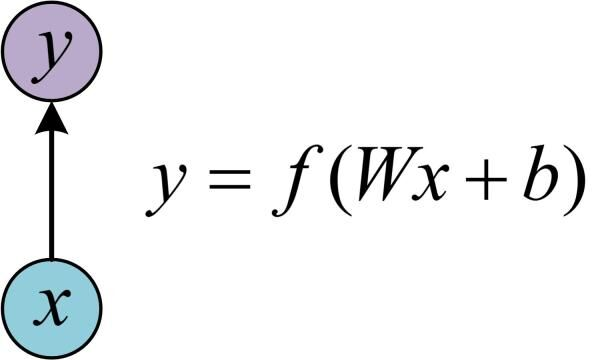
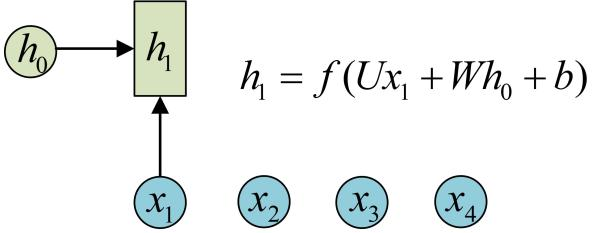
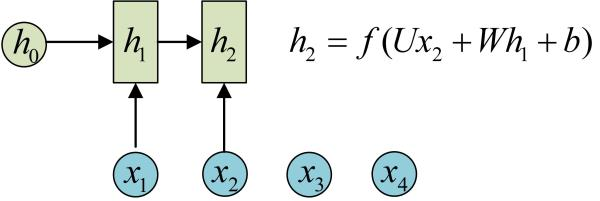
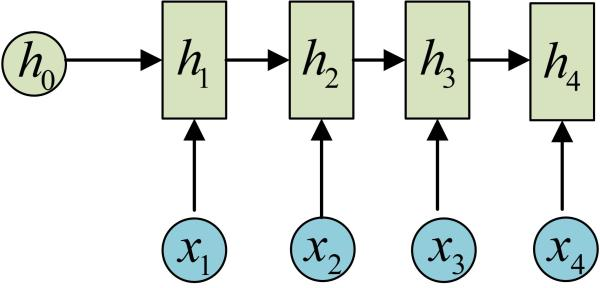
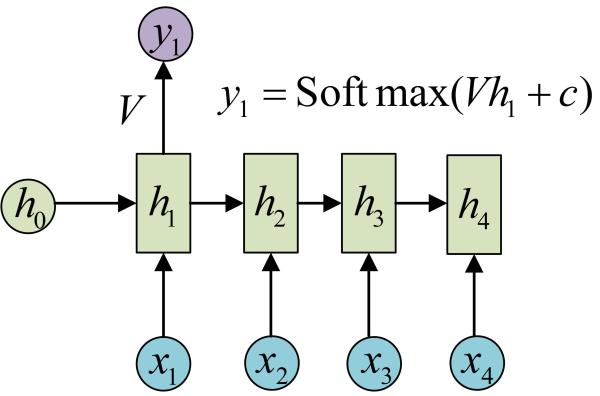
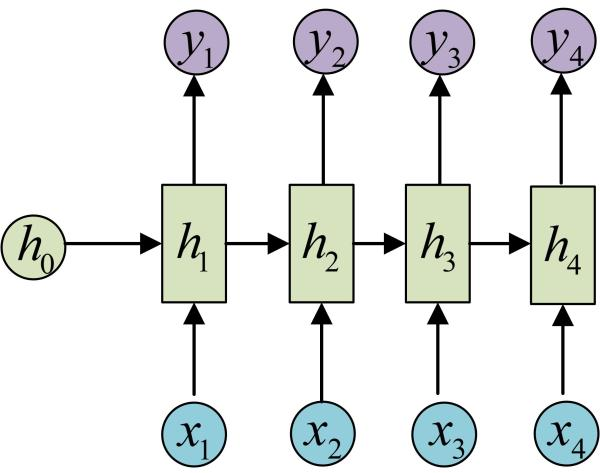

最经典的RNN结构，是$x1, x2, .....xn$，输出为$y1, y2, ...yn$，也就是说，输入和输出序列必须要是等长的。

### 长短期记忆

LSTM具有称为门和单元状态的内部机制，可以控制信息流。单元决定信息的选择、信息量以及存储和释放的时机：通过预测、反向传播误差和梯度下降调整权重的迭代过程来学习何时允许信息进入、离开和删除。

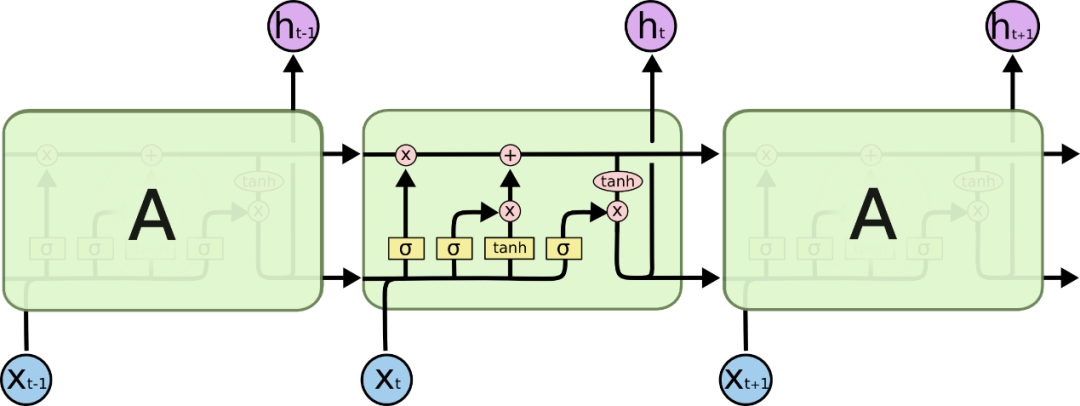

根据图示我们可以看到：LSTM主要有三个门组成，即遗忘门、输入门和输出门。

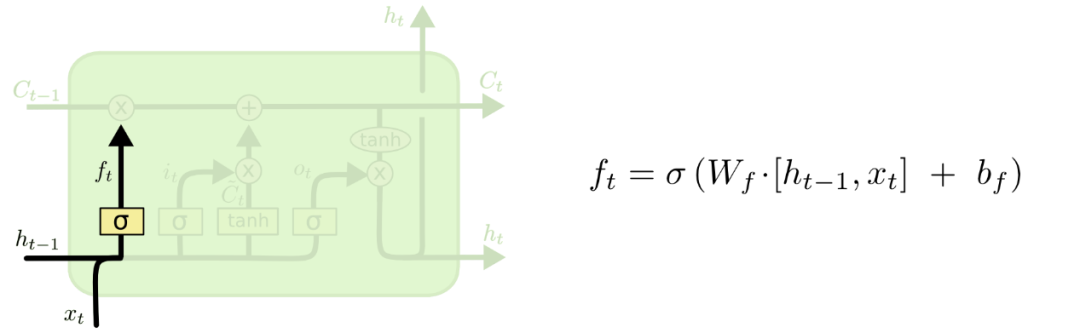

LSTM遗忘门会读取$h_{t-1}$和$x_t$，输出一个在0到1之间的数值，并传递给每个细胞状态$C_{t-1}$。1表示“完全保留”，0表示“完全舍弃”。

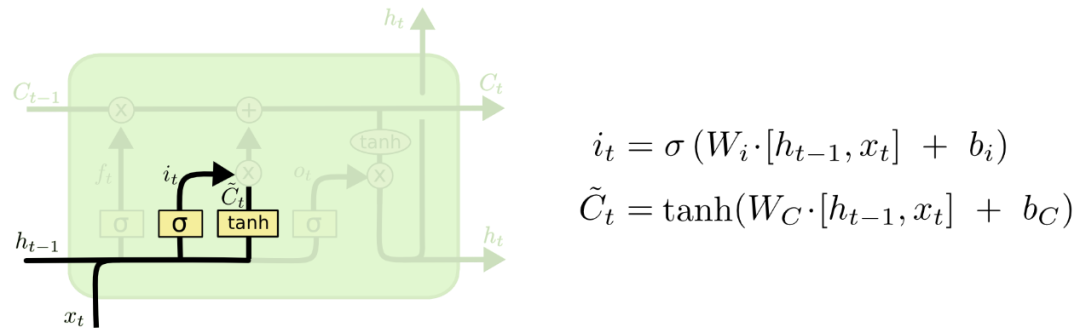

接下来，则由LSTM输入门确定什么样的新信息可以被存放在细胞状态中，这里包含两个部分：首先，sigmoid层决定什么值将要被更新；然后，tanh层创建一个新的候选值向量$\tilde{C_t}$，并在之后将$\tilde{C_t}$加入至状态中。

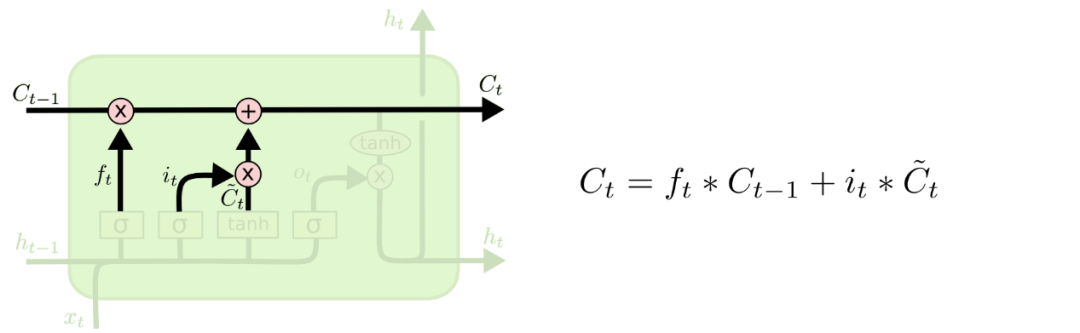

我们将旧状态与$f_t$相乘，丢弃掉确定需要丢弃的信息，并加上$i_t*\tilde{C_t}$，由此得到新的候选值。

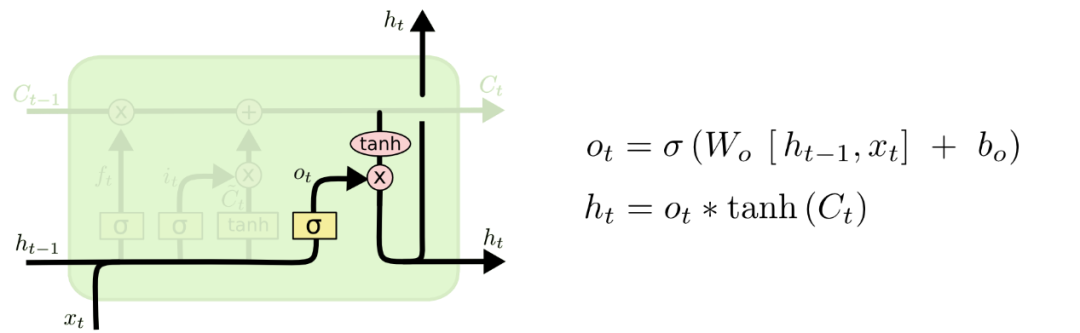

LSTM输出门将基于细胞状态形成一个过滤后的版本。首先，运行sigmoid层来确定细胞状态将要输出哪个部分；接着，通过tanh层处理细胞状态（得到一个在-1到1之间的值）并将它和sigmoid门的输出相乘，最终，LSTM输出门仅会输出我们确定需要的部分。

### 门控循环单元

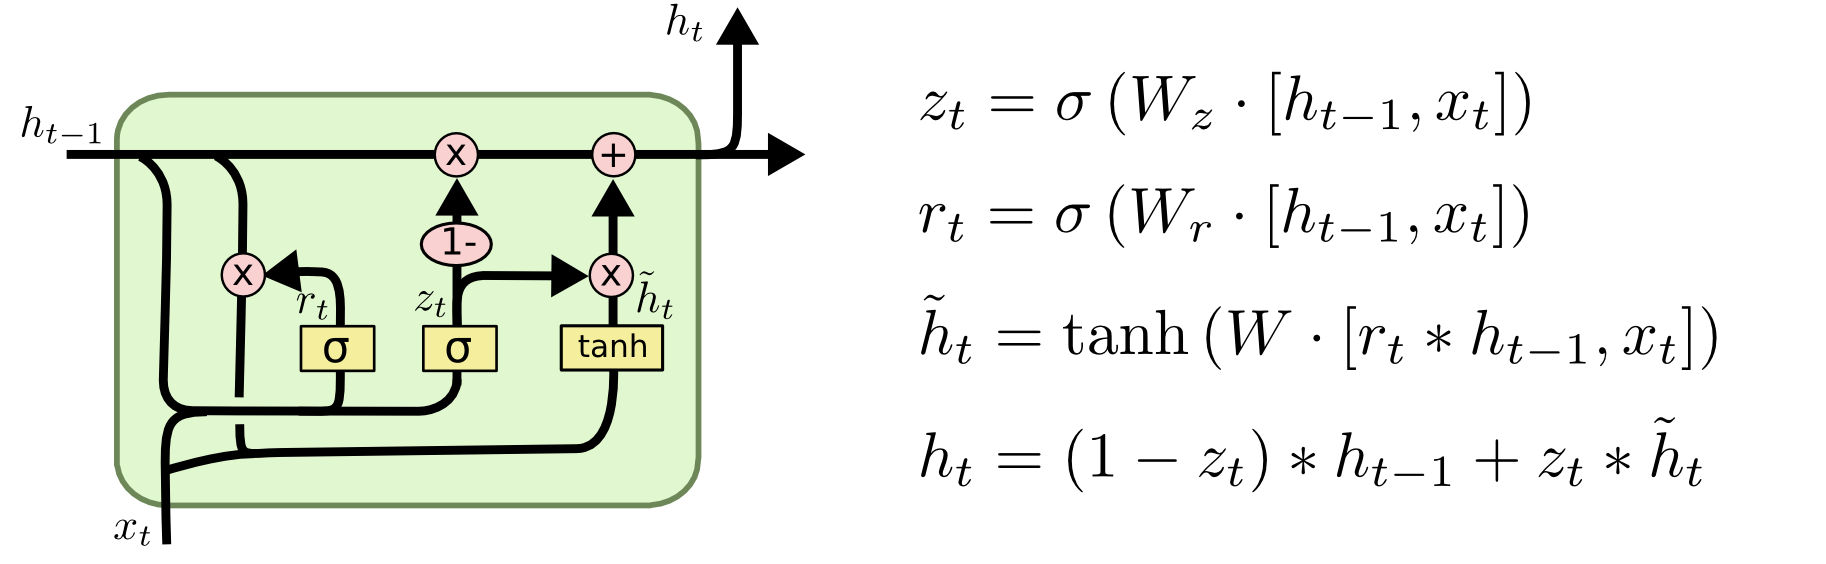

GRU将遗忘门和输入门合成了一个单一的更新门$z_t$。同样还混合了细胞状态和隐藏状态，和其他一些改动。最终的模型比标准的LSTM模型要简单，也是非常流行的变体。
- 更新门$z_t$：$z_{t}$是属于要记住的，反过来$1- z_{t}$则是属于忘记的，相当于对输入$h_{t-1}$、$x_{t}$做了一些更改/变化。
- 重置门$r_t$：相当于先见之明的把输入$h_{t-1}$、$x_{t}$在$z_{t}$/$1- z_{t}$对其做更改/变化之前，先事先存一份原始的。

### 数据要求

![hello](../images/p18.jpg)

样本数量、时间步和特征代表进行预测所需的条件（ 𝑋
 ），而样本和范围代表进行的预测（ 𝑌
 ）。如果以单变量时间序列问题为例，而我们对单步预测（例如，下一个小时）感兴趣，那么前一个时间步的观测值（例如，前四个小时的值，即滞后观测值）被用作输入，输出是下一个时间步的观测值。

重要步骤：
- 在训练集上训练模型。
- 然后，在每个训练时期之后，将验证集用于评估模型，并确保模型不会过度拟合训练模型。
- 模型完成训练后，在测试集中评估模型。
- 在处理时间序列数据时，重要的是要确保验证集和测试集都覆盖了来自训练集的之后时间段，以使模型不会从将来的时间戳信息中受益。

## 基于卷积神经网络的时间序列预测

CNN属于前馈神经网络的一种，特点是每层的神经元节点只响应前一层局部区域范围内的神经元。一个深度卷积神经网络模型，一般由若干卷积层叠加若干全连接层组成，中间包含各种的卷积操作、池化操作。其结构图如下所示：

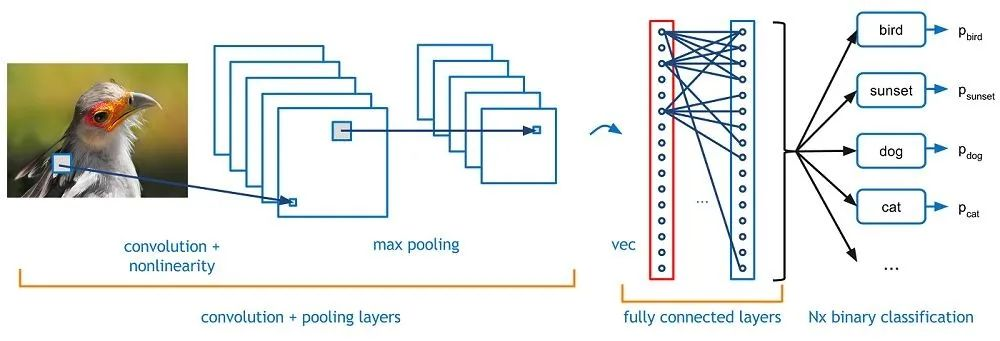

可以看到，CNN主要有三个层组成，从左至右分别为：卷积层、池化层与全连接层。

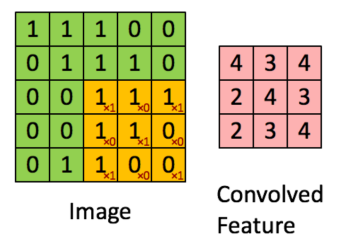

卷积层中最重要的概念是卷积核(图左橙色部分)，卷积核可以理解为是一种特征，将输入和卷积核相乘得到的结果就是输入在这个特征上的投影，这个投影可以称之为特征图。

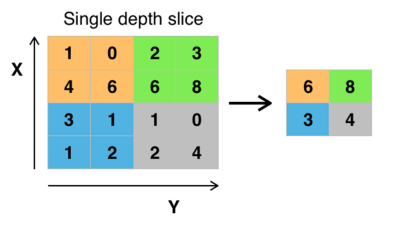

常见的池化有最大值池化(如上图所示)和平均池化两种，顾名思义就是在池化窗口内计算最大值和平均值作为池化结果。池化层的作用主要体现在：特征不变性、特征降维和减少过拟合。

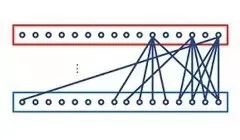

全连接层一般位于整个神经网络的最后，负责将卷积输出的二维特征图（矩阵）转换成一维向量。

对于文本分类和时间序列预测等简单任务，小型的一维卷积神经网络可以替代RNN，而且速度更快。

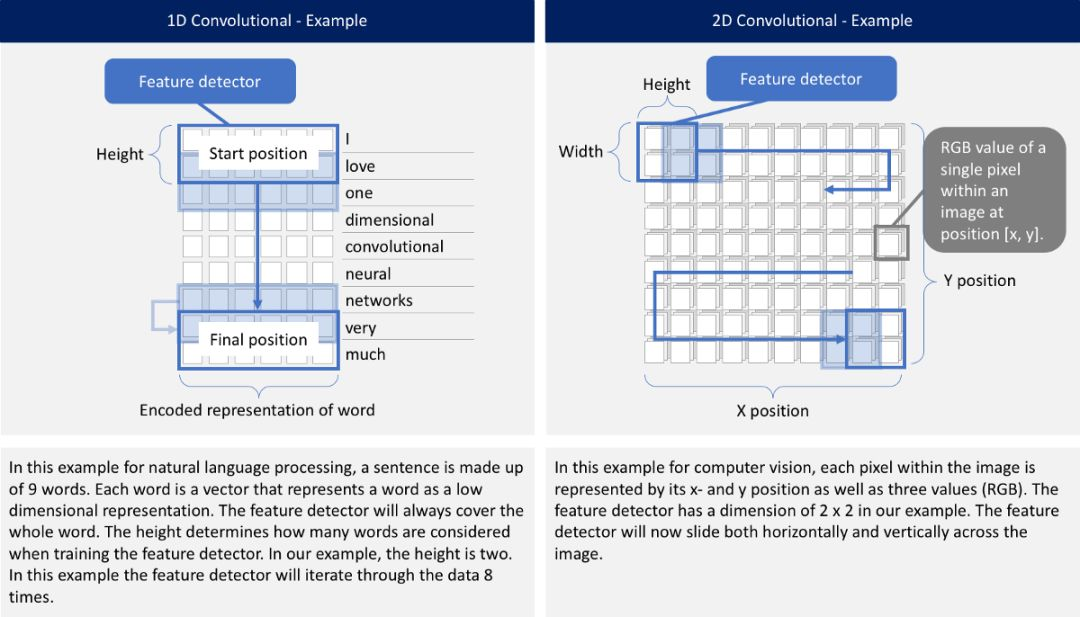

### 数据要求

数据输入维度一般为(样本,特征,时间步)，输出数据维度一般为(样本,特征)。

## LSTM-tensorflow

In [109]:
import tensorflow as tf

# 检查 GPU 是否可用
if tf.test.gpu_device_name():
    print('GPU 设备可用：', tf.test.gpu_device_name())
else:
    print("GPU 未找到，请确保已正确安装 TensorFlow-GPU 版本。")

ModuleNotFoundError: No module named 'tensorflow'

### 数据准备

In [2]:
ts_data = pd.read_csv("../data/energy.csv")
ts_data = pd.DataFrame(ts_data[["load", "temp"]].values, index=pd.to_datetime(ts_data["Unnamed: 0"].values), columns=["load", "temp"])
ts_data = ts_data.asfreq(freq='H') #转换为小时频率的数据
ts_data.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


对于能源预测案例，我们将2014年11月1日至2014年12月31日期间的数据划分为测试集。2014年9月1日至10月31日期间的数据划分为验证集，其他时间作为训练集。

In [3]:
valid_st_data_load = "2014-09-01 00:00:00"
test_st_data_load = "2014-11-01 00:00:00"

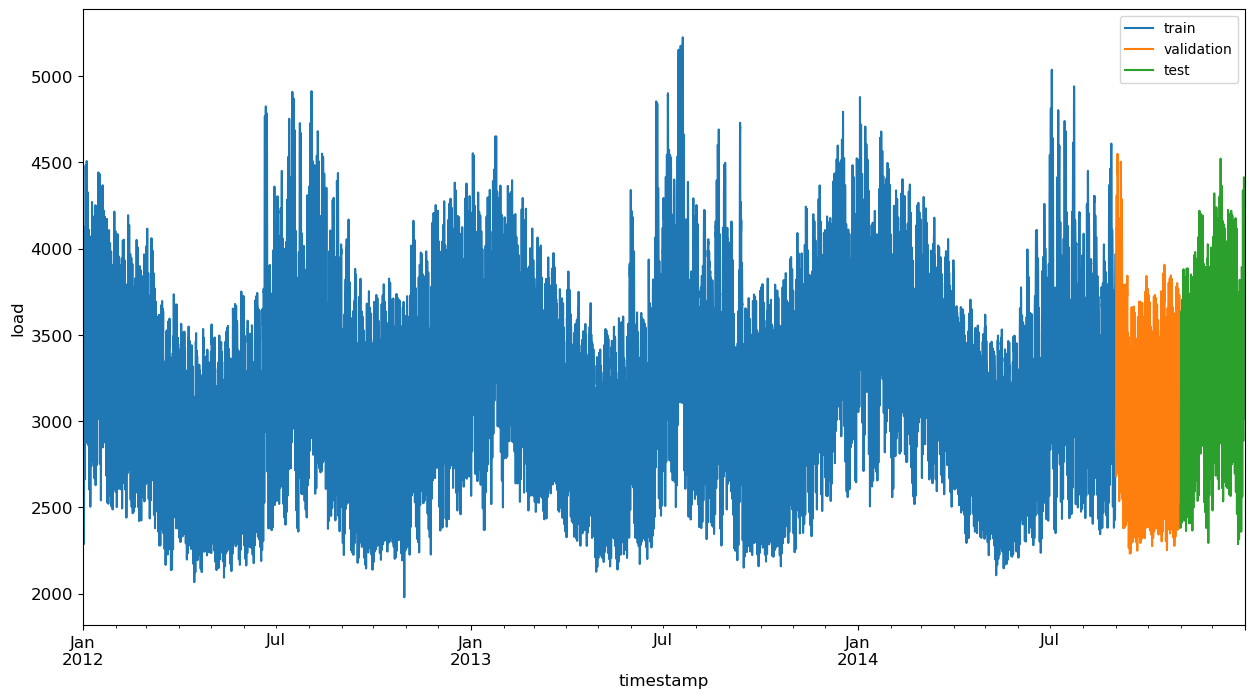

In [4]:
ts_data[ts_data.index < valid_st_data_load][["load"]].rename(columns={
    "load": "train"
}).join(
    ts_data[(ts_data.index >= valid_st_data_load)
            & (ts_data.index < test_st_data_load)][[
                "load"
            ]].rename(columns={"load": "validation"}),
    how="outer",
).join(ts_data[test_st_data_load:][["load"]].rename(columns={"load": "test"}),
       how="outer").plot(y=["train", "validation", "test"],
                         figsize=(15, 8),
                         fontsize=12)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("load", fontsize=12)
plt.show()

我们将$T$（滞后变量的数量）设置为6。这意味着每个样本的输入都是前6个小时负荷值的向量。$T=6$的选择是任意的。我们还将范围设置为1，意味着只预测下一个小时（$t+1$）的输出。

**训练集**

In [8]:
T = 6
HORIZON = 1
#训练集
train = ts_data.copy()[ts_data.index < valid_st_data_load][["load"]]
#归一化
scaler = MinMaxScaler()
train["load"] = scaler.fit_transform(train)
#时移创建滞后和前导数据
train_shifted = train.copy()
train_shifted["y_t+1"] = train_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    train_shifted[str(T - t)] = train_shifted["load"].shift(T - t, freq="H")
y_col = "y_t+1"
X_cols = ["load_t-5", "load_t-4", "load_t-3", "load_t-2", "load_t-1", "load_t"]
train_shifted.columns = ["load_original"] + [y_col] + X_cols

train_shifted = train_shifted.dropna(how="any")
train_shifted.head(5)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23
2012-01-01 08:00:00,0.29,0.35,0.13,0.13,0.15,0.18,0.23,0.29
2012-01-01 09:00:00,0.35,0.37,0.13,0.15,0.18,0.23,0.29,0.35


**验证集**

In [9]:
T = 6
HORIZON = 1
#训练集
valid = ts_data.copy()[(ts_data.index >= valid_st_data_load) & (ts_data.index < test_st_data_load)][["load"]]
#归一化
scaler = MinMaxScaler()
valid["load"] = scaler.fit_transform(valid)
#时移创建滞后和前导数据
valid_shifted = valid.copy()
valid_shifted["y_t+1"] = valid_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    valid_shifted[str(T - t)] = valid_shifted["load"].shift(T - t, freq="H")
y_col = "y_t+1"
X_cols = ["load_t-5", "load_t-4", "load_t-3", "load_t-2", "load_t-1", "load_t"]
valid_shifted.columns = ["load_original"] + [y_col] + X_cols

valid_shifted = valid_shifted.dropna(how="any")
valid_shifted.head(5)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2014-09-01 05:00:00,0.23,0.28,0.28,0.23,0.20,0.19,0.20,0.23
2014-09-01 06:00:00,0.28,0.36,0.23,0.20,0.19,0.20,0.23,0.28
2014-09-01 07:00:00,0.36,0.51,0.20,0.19,0.20,0.23,0.28,0.36
2014-09-01 08:00:00,0.51,0.64,0.19,0.20,0.23,0.28,0.36,0.51
2014-09-01 09:00:00,0.64,0.73,0.20,0.23,0.28,0.36,0.51,0.64


**测试集**

In [10]:
T = 6
HORIZON = 1
#训练集
test = ts_data.copy()[test_st_data_load:][["load"]]
#归一化
scaler = MinMaxScaler()
test["load"] = scaler.fit_transform(test)
#时移创建滞后和前导数据
test_shifted = test.copy()
test_shifted["y_t+1"] = test_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    test_shifted[str(T - t)] = test_shifted["load"].shift(T - t, freq="H")
y_col = "y_t+1"
X_cols = ["load_t-5", "load_t-4", "load_t-3", "load_t-2", "load_t-1", "load_t"]
test_shifted.columns = ["load_original"] + [y_col] + X_cols

test_shifted = test_shifted.dropna(how="any")
test_shifted.head(5)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2014-11-01 05:00:00,0.10,0.19,0.10,0.07,0.05,0.04,0.06,0.10
2014-11-01 06:00:00,0.19,0.31,0.07,0.05,0.04,0.06,0.10,0.19
2014-11-01 07:00:00,0.31,0.40,0.05,0.04,0.06,0.10,0.19,0.31
2014-11-01 08:00:00,0.40,0.48,0.04,0.06,0.10,0.19,0.31,0.40
2014-11-01 09:00:00,0.48,0.51,0.06,0.10,0.19,0.31,0.40,0.48


![hello](../images/p19.jpg)

**转换为张量**

将$X$转换为（样本、时间步、特征）的形式，在此数据集中，我们有23370个样本，6个时间步和1个特征。

In [11]:
y_train = train_shifted[y_col].to_numpy()
X_train = train_shifted[X_cols].to_numpy()

In [12]:
y_valid = valid_shifted[y_col].to_numpy()
X_valid = valid_shifted[X_cols].to_numpy()

In [13]:
y_test = test_shifted[y_col].to_numpy()
X_test = test_shifted[X_cols].to_numpy()

将$X$输入重新构造为三维数组。

In [17]:
X_train = X_train.reshape(X_train.shape[0], T, 1)
X_train.shape

(23370, 6, 1)

In [18]:
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)
X_valid.shape

(1458, 6, 1)

In [19]:
X_test = X_test.reshape(X_test.shape[0], T, 1)
X_test.shape

(1458, 6, 1)

- 单变量模型：单变量时间序列是指由按相等时间增量顺序记录的单个（标量）观测值组成的时间序列。
- 多变量模型：多变量时间序列具有多个时间相关变量，每个变量不仅取决于其过去的值，而且对其他变量也有一定的依赖性。

### 单变量单步预测模型

![hello](../images/p23.jpg)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Model, Sequential

In [21]:
LATENT_DIM = 5 #潜在维度，隐层个数
BATCH_SIZE = 32 #批尺寸，每个小批量的样本数量
EPOCHS = 10 #周期，训练算法循环遍历所有样本的最大次数

In [22]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 1)))
model.add(Dense(HORIZON))

In [23]:
model.compile(optimizer="RMSprop", loss="mse")

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5)                 120       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________


提前停止是一种正则化方法，在使用迭代方法训练机器学习模型时可避免过拟合。

In [25]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

In [26]:
model_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_valid, y_valid),
    callbacks=[earlystop],
    verbose=1,
)

Epoch 1/10
731/731 [==============================] - 7s 6ms/step - loss: 0.0071 - val_loss: 0.0021
Epoch 2/10
731/731 [==============================] - 4s 5ms/step - loss: 9.1719e-04 - val_loss: 0.0013
Epoch 3/10
731/731 [==============================] - 4s 5ms/step - loss: 6.4150e-04 - val_loss: 0.0011
Epoch 4/10
731/731 [==============================] - 4s 5ms/step - loss: 5.7578e-04 - val_loss: 0.0011
Epoch 5/10
731/731 [==============================] - 4s 5ms/step - loss: 5.6536e-04 - val_loss: 0.0010
Epoch 6/10
731/731 [==============================] - 4s 5ms/step - loss: 5.5873e-04 - val_loss: 0.0010
Epoch 7/10
731/731 [==============================] - 4s 5ms/step - loss: 5.5922e-04 - val_loss: 9.8956e-04
Epoch 8/10
731/731 [==============================] - 4s 5ms/step - loss: 5.5510e-04 - val_loss: 0.0011
Epoch 9/10
731/731 [==============================] - 4s 5ms/step - loss: 5.5368e-04 - val_loss: 0.0011
Epoch 10/10
731/731 [==============================] - 4s 5ms/st

In [27]:
ts_predictions = model.predict(X_test)
ts_predictions

array([[0.18],
       [0.3 ],
       [0.42],
       ...,
       [0.66],
       [0.56],
       [0.5 ]], dtype=float32)

In [28]:
#反归一化
ev_ts_data = pd.DataFrame(
    ts_predictions, columns=["t+" + str(t) for t in range(1, HORIZON + 1)]
)
ev_ts_data["timestamp"] = test_shifted.index
ev_ts_data = pd.melt(ev_ts_data, id_vars="timestamp", value_name="prediction", var_name="h")
ev_ts_data["actual"] = np.transpose(y_test).ravel()
ev_ts_data[["prediction", "actual"]] = scaler.inverse_transform(
    ev_ts_data[["prediction", "actual"]]
)
ev_ts_data.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,695.49","2,714.00"
1,2014-11-01 06:00:00,t+1,"2,963.02","2,970.00"
2,2014-11-01 07:00:00,t+1,"3,223.14","3,189.00"
3,2014-11-01 08:00:00,t+1,"3,354.63","3,356.00"
4,2014-11-01 09:00:00,t+1,"3,487.49","3,436.00"


In [29]:
def mape(ts_predictions, actuals):
    """Mean absolute percentage error"""
    return ((ts_predictions - actuals).abs() / actuals).mean()

In [30]:
mape(ev_ts_data["prediction"], ev_ts_data["actual"])

0.0172295417810233

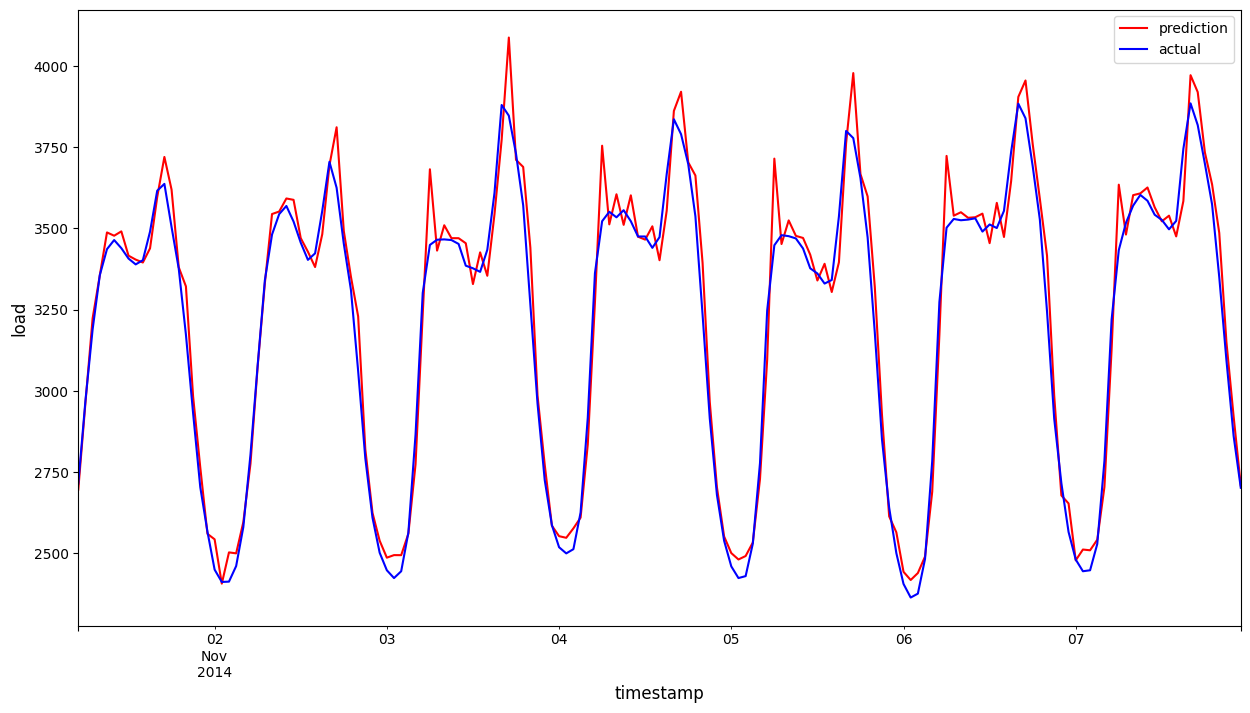

In [31]:
ev_ts_data[ev_ts_data.timestamp < "2014-11-08"].plot(
    x="timestamp", y=["prediction", "actual"], style=["r", "b"], figsize=(15, 8)
)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("load", fontsize=12)
plt.show()

### 多变量单步预测模型

![hello](../images/p22.jpg)

In [33]:
valid_st_data_load = "2014-09-01 00:00:00"
test_st_data_load = "2014-11-01 00:00:00"

In [34]:
T = 6
HORIZON = 1

In [36]:
y_scaler = MinMaxScaler()
y_scaler.fit(train[["load"]])

MinMaxScaler()

In [42]:
train = ts_data.copy()[ts_data.index < valid_st_data_load][["load", "temp"]]
X_scaler = MinMaxScaler()
train[["load", "temp"]] = X_scaler.fit_transform(train)

#时移创建滞后和前导数据
train_shifted = train.copy()
train_shifted["y_t+1"] = train_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    train_shifted["load" + str(T - t)] = train_shifted["load"].shift(T - t, freq="H")
    train_shifted["temp" + str(T - t)] = train_shifted["temp"].shift(T - t, freq="H")
y_col = "y_t+1"
X_cols_load = ["load_t-5", "load_t-4", "load_t-3", "load_t-2", "load_t-1", "load_t"]
X_cols_temp = ["temp_t-5", "temp_t-4", "temp_t-3", "temp_t-2", "temp_t-1", "temp_t"]
train_shifted.columns = ["load_original"] + ["temp_original"] + [y_col] + X_cols_load + X_cols_temp

train_shifted = train_shifted.dropna(how="any")
train_shifted.head(5)

,load_original,temp_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t,temp_t-5,temp_t-4,temp_t-3,temp_t-2,temp_t-1,temp_t
2012-01-01 05:00:00,0.15,0.41,0.18,0.22,0.42,0.18,0.43,0.14,0.40,0.13,0.41,0.13,0.42,0.15,0.41
2012-01-01 06:00:00,0.18,0.40,0.23,0.18,0.43,0.14,0.40,0.13,0.41,0.13,0.42,0.15,0.41,0.18,0.40
2012-01-01 07:00:00,0.23,0.39,0.29,0.14,0.40,0.13,0.41,0.13,0.42,0.15,0.41,0.18,0.40,0.23,0.39
2012-01-01 08:00:00,0.29,0.39,0.35,0.13,0.41,0.13,0.42,0.15,0.41,0.18,0.40,0.23,0.39,0.29,0.39
2012-01-01 09:00:00,0.35,0.43,0.37,0.13,0.42,0.15,0.41,0.18,0.40,0.23,0.39,0.29,0.39,0.35,0.43


In [43]:
valid = ts_data.copy()[(ts_data.index >= valid_st_data_load) & (ts_data.index < test_st_data_load)][["load", "temp"]]
X_scaler = MinMaxScaler()
valid[["load", "temp"]] = X_scaler.fit_transform(valid)

#时移创建滞后和前导数据
valid_shifted = valid.copy()
valid_shifted["y_t+1"] = valid_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    valid_shifted["load" + str(T - t)] = valid_shifted["load"].shift(T - t, freq="H")
    valid_shifted["temp" + str(T - t)] = valid_shifted["temp"].shift(T - t, freq="H")
y_col = "y_t+1"
X_cols_load = ["load_t-5", "load_t-4", "load_t-3", "load_t-2", "load_t-1", "load_t"]
X_cols_temp = ["temp_t-5", "temp_t-4", "temp_t-3", "temp_t-2", "temp_t-1", "temp_t"]
valid_shifted.columns = ["load_original"] + ["temp_original"] + [y_col] + X_cols_load + X_cols_temp

valid_shifted = valid_shifted.dropna(how="any")
valid_shifted.head(5)

,load_original,temp_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t,temp_t-5,temp_t-4,temp_t-3,temp_t-2,temp_t-1,temp_t
2014-09-01 05:00:00,0.23,0.67,0.28,0.28,0.73,0.23,0.71,0.20,0.69,0.19,0.67,0.20,0.67,0.23,0.67
2014-09-01 06:00:00,0.28,0.66,0.36,0.23,0.71,0.20,0.69,0.19,0.67,0.20,0.67,0.23,0.67,0.28,0.66
2014-09-01 07:00:00,0.36,0.66,0.51,0.20,0.69,0.19,0.67,0.20,0.67,0.23,0.67,0.28,0.66,0.36,0.66
2014-09-01 08:00:00,0.51,0.69,0.64,0.19,0.67,0.20,0.67,0.23,0.67,0.28,0.66,0.36,0.66,0.51,0.69
2014-09-01 09:00:00,0.64,0.76,0.73,0.20,0.67,0.23,0.67,0.28,0.66,0.36,0.66,0.51,0.69,0.64,0.76


In [44]:
test = ts_data.copy()[test_st_data_load:][["load", "temp"]]
X_scaler = MinMaxScaler()
test[["load", "temp"]] = X_scaler.fit_transform(test)

#时移创建滞后和前导数据
test_shifted = test.copy()
test_shifted["y_t+1"] = test_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    test_shifted["load" + str(T - t)] = test_shifted["load"].shift(T - t, freq="H")
    test_shifted["temp" + str(T - t)] = test_shifted["temp"].shift(T - t, freq="H")
y_col = "y_t+1"
X_cols_load = ["load_t-5", "load_t-4", "load_t-3", "load_t-2", "load_t-1", "load_t"]
X_cols_temp = ["temp_t-5", "temp_t-4", "temp_t-3", "temp_t-2", "temp_t-1", "temp_t"]
test_shifted.columns = ["load_original"] + ["temp_original"] + [y_col] + X_cols_load + X_cols_temp

test_shifted = test_shifted.dropna(how="any")
test_shifted.head(5)

,load_original,temp_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t,temp_t-5,temp_t-4,temp_t-3,temp_t-2,temp_t-1,temp_t
2014-11-01 05:00:00,0.10,0.52,0.19,0.10,0.54,0.07,0.52,0.05,0.50,0.04,0.50,0.06,0.50,0.10,0.52
2014-11-01 06:00:00,0.19,0.52,0.31,0.07,0.52,0.05,0.50,0.04,0.50,0.06,0.50,0.10,0.52,0.19,0.52
2014-11-01 07:00:00,0.31,0.54,0.40,0.05,0.50,0.04,0.50,0.06,0.50,0.10,0.52,0.19,0.52,0.31,0.54
2014-11-01 08:00:00,0.40,0.55,0.48,0.04,0.50,0.06,0.50,0.10,0.52,0.19,0.52,0.31,0.54,0.40,0.55
2014-11-01 09:00:00,0.48,0.60,0.51,0.06,0.50,0.10,0.52,0.19,0.52,0.31,0.54,0.40,0.55,0.48,0.60


In [47]:
y_train = train_shifted[y_col].to_numpy()
X_train = train_shifted[X_cols_load+X_cols_temp].to_numpy()

In [48]:
y_valid = valid_shifted[y_col].to_numpy()
X_valid = valid_shifted[X_cols_load+X_cols_temp].to_numpy()

In [49]:
y_test = test_shifted[y_col].to_numpy()
X_test = test_shifted[X_cols_load+X_cols_temp].to_numpy()

In [50]:
X_train = X_train.reshape(X_train.shape[0], T, 2)
X_train.shape

(23370, 6, 2)

In [52]:
X_valid = X_valid.reshape(X_valid.shape[0], T, 2)
X_valid.shape

(1458, 6, 2)

In [54]:
X_test = X_test.reshape(X_test.shape[0], T, 2)
X_test.shape

(1458, 6, 2)

In [45]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 50

model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 2)))
model.add(Dense(HORIZON))

In [46]:
model.compile(optimizer="RMSprop", loss="mse")

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 5)                 135       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


In [55]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

In [56]:
model_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_valid, y_valid),
    callbacks=[earlystop],
    verbose=1,
)

Epoch 1/50
731/731 [==============================] - 7s 7ms/step - loss: 0.0077 - val_loss: 0.0036
Epoch 2/50
731/731 [==============================] - 4s 6ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 3/50
731/731 [==============================] - 4s 5ms/step - loss: 7.4624e-04 - val_loss: 0.0013
Epoch 4/50
731/731 [==============================] - 3s 5ms/step - loss: 6.3155e-04 - val_loss: 0.0011
Epoch 5/50
731/731 [==============================] - 3s 5ms/step - loss: 5.9396e-04 - val_loss: 0.0010
Epoch 6/50
731/731 [==============================] - 4s 5ms/step - loss: 5.7245e-04 - val_loss: 0.0010
Epoch 7/50
731/731 [==============================] - 4s 5ms/step - loss: 5.5901e-04 - val_loss: 9.8911e-04
Epoch 8/50
731/731 [==============================] - 4s 5ms/step - loss: 5.4499e-04 - val_loss: 9.1877e-04
Epoch 9/50
731/731 [==============================] - 3s 5ms/step - loss: 5.3665e-04 - val_loss: 9.0747e-04
Epoch 10/50
731/731 [==============================] - 4s 5m

In [57]:
ts_predictions = model.predict(X_test)
ts_predictions

array([[0.2 ],
       [0.31],
       [0.42],
       ...,
       [0.62],
       [0.54],
       [0.47]], dtype=float32)

In [58]:
ev_ts_data = pd.DataFrame(
    ts_predictions, columns=["t+" + str(t) for t in range(1, HORIZON + 1)]
)
ev_ts_data["timestamp"] = test_shifted.index
ev_ts_data = pd.melt(ev_ts_data, id_vars="timestamp", value_name="prediction", var_name="h")
ev_ts_data["actual"] = np.transpose(y_test).ravel()
ev_ts_data[["prediction", "actual"]] = scaler.inverse_transform(
    ev_ts_data[["prediction", "actual"]]
)
ev_ts_data.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,727.34","2,714.00"
1,2014-11-01 06:00:00,t+1,"2,972.91","2,970.00"
2,2014-11-01 07:00:00,t+1,"3,218.25","3,189.00"
3,2014-11-01 08:00:00,t+1,"3,327.38","3,356.00"
4,2014-11-01 09:00:00,t+1,"3,477.49","3,436.00"


In [59]:
def mape(ts_predictions, actuals):
    """Mean absolute percentage error"""
    return ((ts_predictions - actuals).abs() / actuals).mean()

In [60]:
mape(ev_ts_data["prediction"], ev_ts_data["actual"])

0.015202632380089148

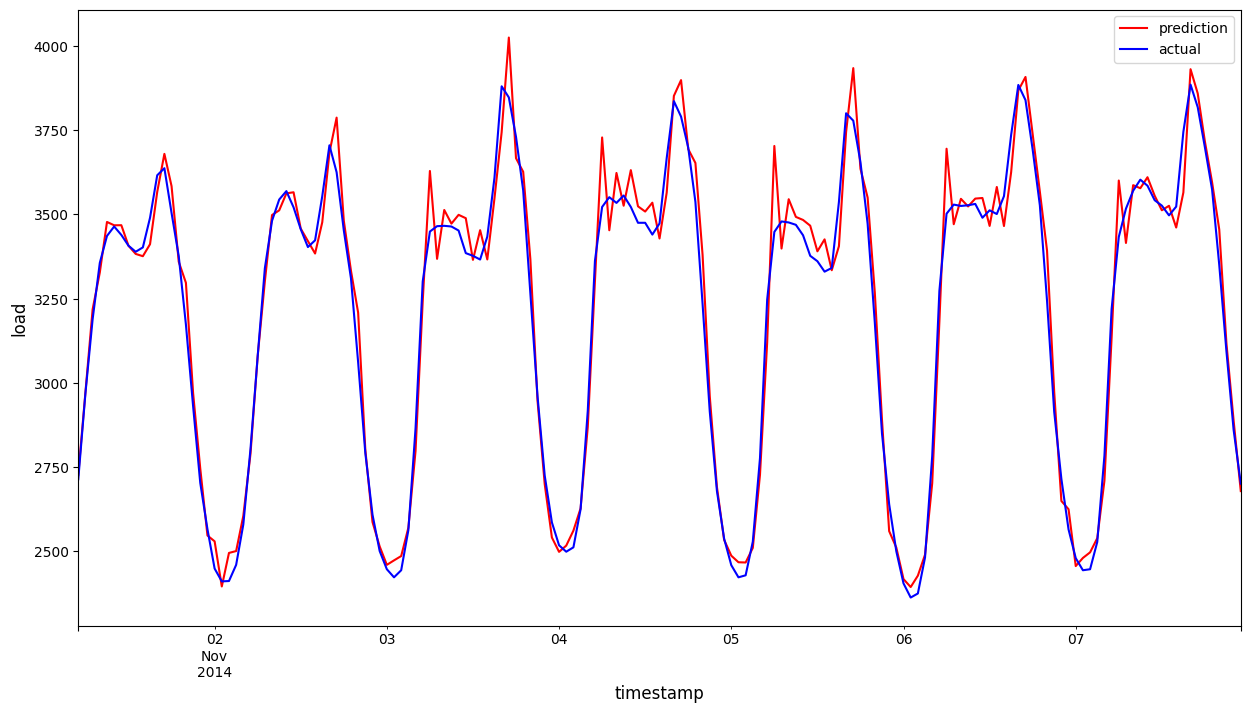

In [61]:
ev_ts_data[ev_ts_data.timestamp < "2014-11-08"].plot(
    x="timestamp", y=["prediction", "actual"], style=["r", "b"], figsize=(15, 8)
)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("load", fontsize=12)
plt.show()

## LSTM-torch

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [110]:
# 检查 GPU 是否可用
if torch.cuda.is_available():
    print('GPU 设备可用：', torch.cuda.get_device_name(0))
else:
    print("GPU 未找到，请确保已正确安装 PyTorch 并启用 CUDA 支持。")

GPU 设备可用： NVIDIA GeForce MX350


### 数据准备

In [139]:
ts_data = pd.read_csv("../data/energy.csv")
ts_data = pd.DataFrame(ts_data[["load", "temp"]].values, index=pd.to_datetime(ts_data["Unnamed: 0"].values), columns=["load", "temp"])
ts_data = ts_data.asfreq(freq='H') #转换为小时频率的数据
ts_data.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [140]:
#不包含时间维度的数据集划分
def split_dataset(df, test_size, valid_size, x_feature_list, y_feature_list):
    # 假设X是特征，y是标签
    X = df.copy()[x_feature_list]
    y = df.copy()[x_feature_list]
    # 划分为训练集和临时集合
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=42)
    # 进一步将临时集合划分为测试集和验证集
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=valid_size, random_state=42)
    
    #归一化
    X_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    #训练集
    X_train[x_feature_list] = X_scaler.fit_transform(X_train)
    X_train = X_train.values.astype('float32')
    #验证集
    X_val[x_feature_list] = X_scaler.fit_transform(X_val)
    X_val = X_val.values.astype('float32')
    #测试集
    X_test[x_feature_list] = X_scaler.fit_transform(X_test)
    X_test = X_test.values.astype('float32')
    
    #标签
    y_train[y_feature_list] = y_scaler.fit_transform(y_train)
    y_train = y_train.values.astype('float32')
    y_val[y_feature_list] = y_scaler.fit_transform(y_val)
    y_val = y_val.values.astype('float32')
    y_test[y_feature_list] = y_scaler.fit_transform(y_test)
    y_test = y_test.values.astype('float32')
    return y_scaler, X_train, X_val, X_test, y_train, y_val, y_test

In [141]:
#包含时间维度的数据集划分
def divide_dataset(df, test_date, valid_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [142]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据
    for i in range(lookback, len(feature) - delay):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader
    loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

### 模型训练

In [143]:
def train(train_loader, valid_loader, n_epochs, input_dim, out_dim, verbose=True, plots=True):
    #LSTM
    class LSTM(nn.Module):
        def __init__(self):
            super().__init__()
            self.lstm = nn.LSTM(input_size=input_dim, hidden_size=5, num_layers=1, batch_first=True)
            self.linear = nn.Linear(in_features=5, out_features=out_dim)
        def forward(self, x):
            x, _ = self.lstm(x)
            x = self.linear(x)
            return x
        
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #训练模型
    model = LSTM().to(device)
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()

    # 损失函数值
    train_losses, val_losses = [], []

    for epoch in range(n_epochs):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch)[:,-1:,:]
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)[:,-1:,:]
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    #绘制损失函数图
    if plots:
        plot_loss(train_losses, val_losses)
    return model

### 模型预测

In [152]:
def predict(model, X_train, X_valid, X_test, y_true, lookback, delay, scaler):
    lookback = lookback - 1 #包含当前时间点
    #数据集长度
    train_size = len(X_train) + lookback + delay
    valid_size = len(X_valid) + lookback + delay
    test_size = len(X_test) + lookback + delay
    
    #时间序列形状
    timeseries_y = y_true.values
    timeseries_x = y_true.index
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        X_train = X_train.to(device) #将数据应用到GPU
        y_pred = model(X_train)
        y_pred = y_pred[:, -1, -1:] #取最后一个输出
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        train_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        train_plot_x = timeseries_x[: train_size]
        '''验证集设置'''
        X_valid = X_valid.to(device)
        y_pred = model(X_valid)
        y_pred = y_pred[:, -1, -1:]
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        valid_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        X_test = X_test.to(device)
        y_pred = model(X_test)
        y_pred = y_pred[:, -1, -1:]
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        test_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, )) + [np.nan]*(delay-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

### 结果分析

In [145]:
#损失函数图
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(val_losses, linestyle='-',color = '#11b3b6')
    plt.plot(train_losses, linestyle='-',color = '#f14643')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Progress")
    plt.legend(["Validation", "Training"])
    plt.show()

In [146]:
# 静态图
def static_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
    #绘图，原始图，训练图，验证图，测试图
    fig = plt.figure(1, (10, 5))
    ax = fig.add_subplot(1,1,1)
    plt.style.use('seaborn-v0_8-paper') #绘制背景色
    plt.grid(axis = 'y',linewidth=0.35) #绘制网格
    plt.title('true-predict-curve ') #图标题
    plt.xticks(rotation = 45) #rotation文字旋转方向
    ax.plot(timeseries_x, timeseries_y, linestyle='-',color = '#11b3b6',label = 'true_curve')
    ax.plot(train_plot_x, train_plot_y, linestyle='--',label = 'train_predict_curve')
    ax.plot(valid_plot_x, valid_plot_y, linestyle='--',label = 'valid_predict_curve')
    ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'test_predict_curve')
    ax.legend(frameon=False) #绘制图例
    plt.xlabel('Time')
    plt.ylabel(y_true.columns.values[0])
    plt.show()

In [147]:
# 动态图
def dynamic_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
    # 准备画布
    fig = go.Figure()

    # 添加实际数据
    fig.add_trace(
        go.Scatter(
            x=timeseries_x,
            y=timeseries_y.reshape(timeseries_y.shape[0], ),
            mode='lines',
            name='true_curve',
            line = dict(color=None, width=2, dash=None)
        ))

    # 添加训练预测数据
    fig.add_trace(
        go.Scatter(
            x=train_plot_x,
            y=train_plot_y,
            mode='lines',
            name='train_predict_curve',
            line = dict(color=None, width=2, dash=None)
        ))

    # 添加验证预测数据
    fig.add_trace(
        go.Scatter(
            x=valid_plot_x,
            y=valid_plot_y,
            mode='lines',
            name='valid_predict_curve',
            line = dict(color=None, width=2, dash=None)
        ))

    # 添加测试预测数据
    fig.add_trace(
        go.Scatter(
            x=test_plot_x,
            y=test_plot_y,
            mode='lines',
            name='test_predict_curve',
            line = dict(color=None, width=2, dash=None)
        ))

    #更新图表的排版
    fig.update_layout(
        title='true-predict-curve',
        xaxis=dict(title="date"),
        yaxis=dict(title="load"),
        width=900,  #图表宽度
        height=500,  #图表长度
        template="simple_white"  #图表风格
    )

    fig.show()

### 单变量单步预测模型

In [148]:
# 构造参数字典
params = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 1) y_train shape: (23376, 1)
x_valid shape: (1464, 1) y_valid shape: (1464, 1)
x_test shape: (1464, 1) y_test shape: (1464, 1)


In [149]:
lookback = 6
delay = 1
batch_size = 32
X_train, y_train, train_loader = create_dataset(x_train, y_train, lookback, delay, batch_size)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, lookback, delay, batch_size)
X_test, y_test, test_loader = create_dataset(x_test, y_test, lookback, delay, batch_size)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23370, 6, 1]),y_size: torch.Size([23370, 1, 1]),loader_len: 731
X_size: torch.Size([1458, 6, 1]),y_size: torch.Size([1458, 1, 1]),loader_len: 46
X_size: torch.Size([1458, 6, 1]),y_size: torch.Size([1458, 1, 1]),loader_len: 46


Epoch [1/10], Training Loss: 0.0126, Validation Loss: 0.0085
Epoch [2/10], Training Loss: 0.0022, Validation Loss: 0.0029
Epoch [3/10], Training Loss: 0.0012, Validation Loss: 0.0017
Epoch [4/10], Training Loss: 0.0008, Validation Loss: 0.0013
Epoch [5/10], Training Loss: 0.0007, Validation Loss: 0.0011
Epoch [6/10], Training Loss: 0.0006, Validation Loss: 0.0010
Epoch [7/10], Training Loss: 0.0006, Validation Loss: 0.0011
Epoch [8/10], Training Loss: 0.0006, Validation Loss: 0.0010
Epoch [9/10], Training Loss: 0.0006, Validation Loss: 0.0010
Epoch [10/10], Training Loss: 0.0005, Validation Loss: 0.0010


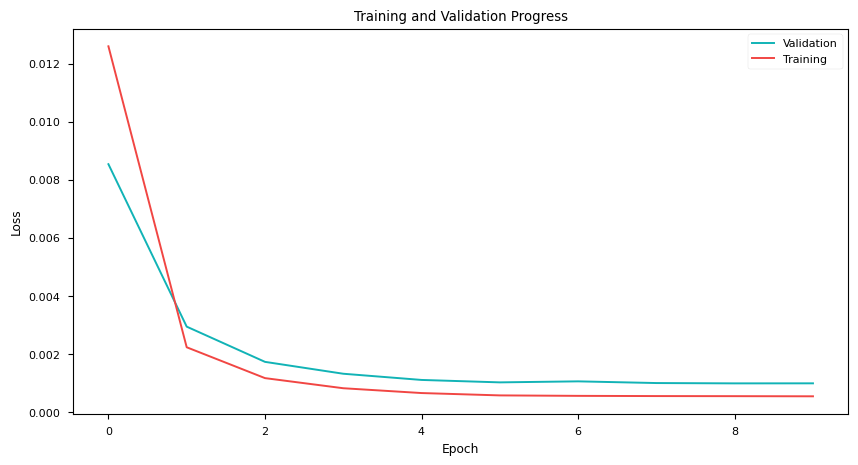

In [150]:
n_epochs = 10
input_dim = 1
out_dim = 1
model = train(train_loader, valid_loader, n_epochs, input_dim, out_dim, verbose=True, plots=True)

In [153]:
y_true = ts_data[['load']]
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    model, X_train, X_valid, X_test, y_true, lookback, delay, scaler)

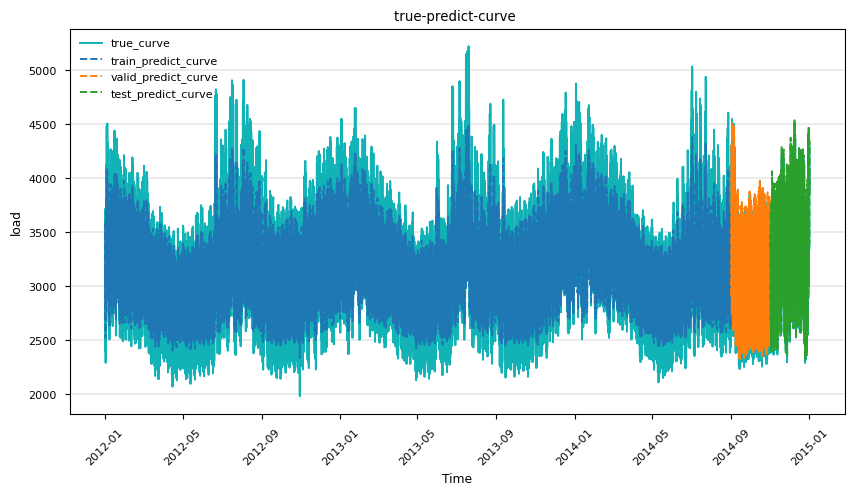

In [154]:
# 静态图
static_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

In [39]:
# #动态图
# dynamic_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

### 单变量多步预测模型

In [82]:
# 构造参数字典
params = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 1) y_train shape: (23376, 1)
x_valid shape: (1464, 1) y_valid shape: (1464, 1)
x_test shape: (1464, 1) y_test shape: (1464, 1)


In [83]:
lookback = 6
delay = 3
batch_size = 32
X_train, y_train, train_loader = create_dataset(x_train, y_train, lookback, delay, batch_size)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, lookback, delay, batch_size)
X_test, y_test, test_loader = create_dataset(x_test, y_test, lookback, delay, batch_size)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 1]),y_size: torch.Size([23368, 3, 1]),loader_len: 731
X_size: torch.Size([1456, 6, 1]),y_size: torch.Size([1456, 3, 1]),loader_len: 46
X_size: torch.Size([1456, 6, 1]),y_size: torch.Size([1456, 3, 1]),loader_len: 46


Epoch [1/10], Training Loss: 0.0555, Validation Loss: 0.0360
Epoch [2/10], Training Loss: 0.0161, Validation Loss: 0.0201
Epoch [3/10], Training Loss: 0.0089, Validation Loss: 0.0137
Epoch [4/10], Training Loss: 0.0069, Validation Loss: 0.0119
Epoch [5/10], Training Loss: 0.0062, Validation Loss: 0.0114
Epoch [6/10], Training Loss: 0.0058, Validation Loss: 0.0107
Epoch [7/10], Training Loss: 0.0055, Validation Loss: 0.0097
Epoch [8/10], Training Loss: 0.0051, Validation Loss: 0.0090
Epoch [9/10], Training Loss: 0.0048, Validation Loss: 0.0087
Epoch [10/10], Training Loss: 0.0047, Validation Loss: 0.0084


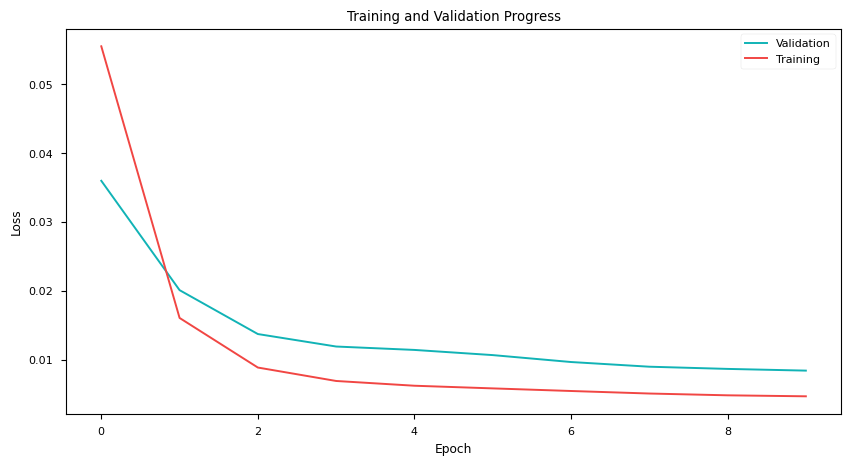

In [84]:
n_epochs = 10
input_dim = 1
out_dim = 3
model = train(train_loader, valid_loader, n_epochs, input_dim, out_dim, verbose=True, plots=True)

In [43]:
y_true = ts_data[['load']]
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    model, X_train, X_valid, X_test, y_true, lookback, delay, scaler)

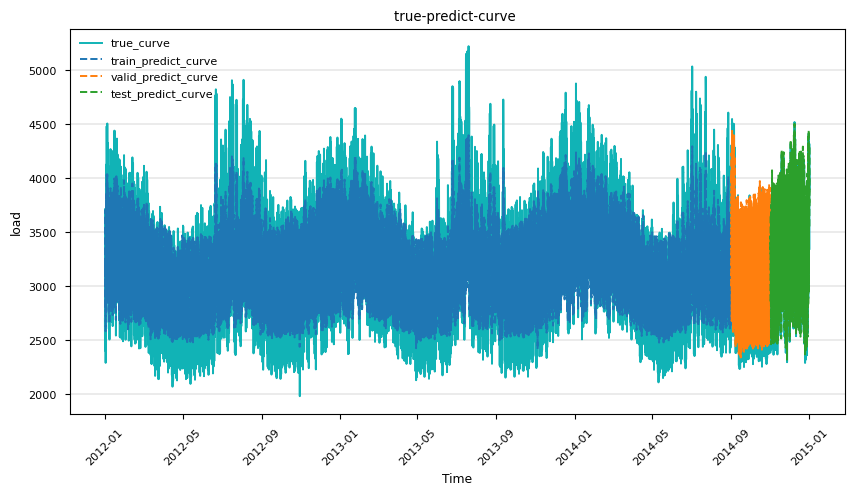

In [47]:
# 静态图
static_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

In [24]:
# #动态图
# dynamic_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

### 多变量单步预测模型

In [62]:
# 构造参数字典
params = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", "temp"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 1)
x_valid shape: (1464, 2) y_valid shape: (1464, 1)
x_test shape: (1464, 2) y_test shape: (1464, 1)


In [63]:
lookback = 6
delay = 1
batch_size = 32
X_train, y_train, train_loader = create_dataset(x_train, y_train, lookback, delay, batch_size)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, lookback, delay, batch_size)
X_test, y_test, test_loader = create_dataset(x_test, y_test, lookback, delay, batch_size)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23370, 6, 2]),y_size: torch.Size([23370, 1, 1]),loader_len: 731
X_size: torch.Size([1458, 6, 2]),y_size: torch.Size([1458, 1, 1]),loader_len: 46
X_size: torch.Size([1458, 6, 2]),y_size: torch.Size([1458, 1, 1]),loader_len: 46


Epoch [1/10], Training Loss: 0.0894, Validation Loss: 0.0307
Epoch [2/10], Training Loss: 0.0137, Validation Loss: 0.0193
Epoch [3/10], Training Loss: 0.0078, Validation Loss: 0.0100
Epoch [4/10], Training Loss: 0.0034, Validation Loss: 0.0039
Epoch [5/10], Training Loss: 0.0017, Validation Loss: 0.0028
Epoch [6/10], Training Loss: 0.0013, Validation Loss: 0.0023
Epoch [7/10], Training Loss: 0.0011, Validation Loss: 0.0019
Epoch [8/10], Training Loss: 0.0009, Validation Loss: 0.0015
Epoch [9/10], Training Loss: 0.0008, Validation Loss: 0.0013
Epoch [10/10], Training Loss: 0.0007, Validation Loss: 0.0011


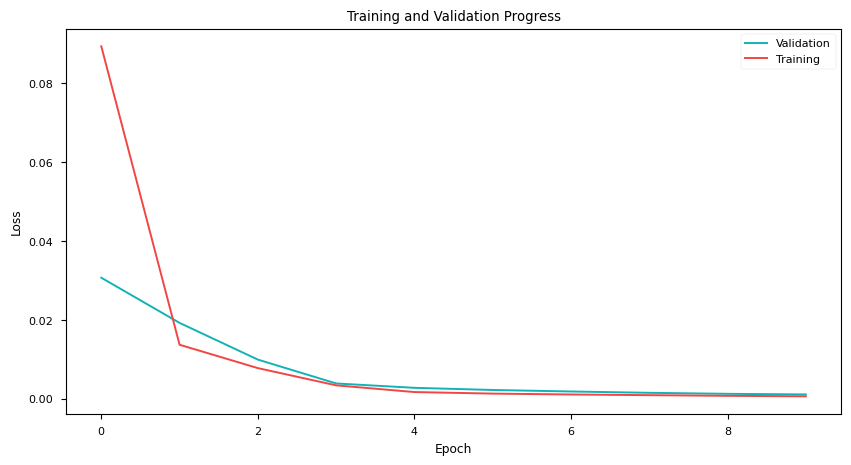

In [64]:
n_epochs = 10
input_dim = 2
out_dim = 1
model = train(train_loader, valid_loader, n_epochs, input_dim, out_dim, verbose=True)

In [65]:
y_true = ts_data[['load']]
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    model, X_train, X_valid, X_test, y_true, lookback, delay, scaler)

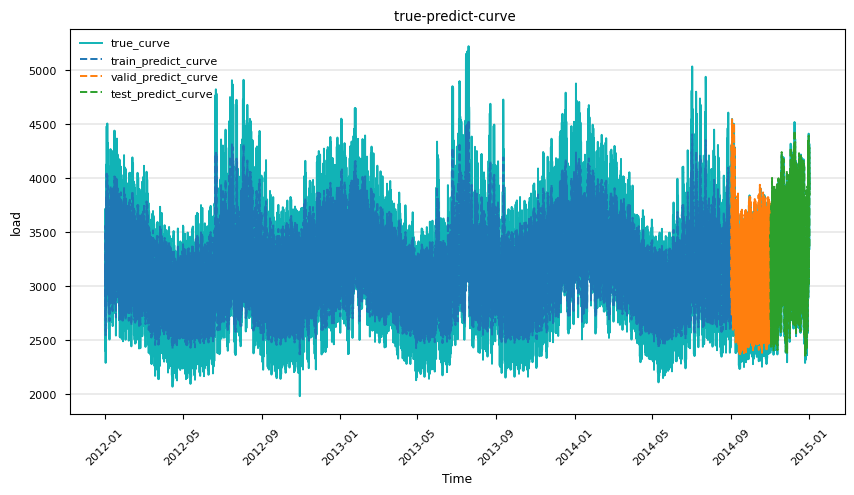

In [66]:
# 静态图
static_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

In [59]:
# #动态图
# dynamic_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

### 多变量多步预测模型

In [67]:
# 构造参数字典
params = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", "temp"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 1)
x_valid shape: (1464, 2) y_valid shape: (1464, 1)
x_test shape: (1464, 2) y_test shape: (1464, 1)


In [68]:
lookback = 6
delay = 3
batch_size = 32
X_train, y_train, train_loader = create_dataset(x_train, y_train, lookback, delay, batch_size)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, lookback, delay, batch_size)
X_test, y_test, test_loader = create_dataset(x_test, y_test, lookback, delay, batch_size)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 2]),y_size: torch.Size([23368, 3, 1]),loader_len: 731
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 1]),loader_len: 46
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 1]),loader_len: 46


Epoch [1/10], Training Loss: 0.0629, Validation Loss: 0.0320
Epoch [2/10], Training Loss: 0.0129, Validation Loss: 0.0189
Epoch [3/10], Training Loss: 0.0079, Validation Loss: 0.0129
Epoch [4/10], Training Loss: 0.0061, Validation Loss: 0.0112
Epoch [5/10], Training Loss: 0.0054, Validation Loss: 0.0098
Epoch [6/10], Training Loss: 0.0050, Validation Loss: 0.0091
Epoch [7/10], Training Loss: 0.0047, Validation Loss: 0.0084
Epoch [8/10], Training Loss: 0.0046, Validation Loss: 0.0081
Epoch [9/10], Training Loss: 0.0044, Validation Loss: 0.0081
Epoch [10/10], Training Loss: 0.0044, Validation Loss: 0.0079


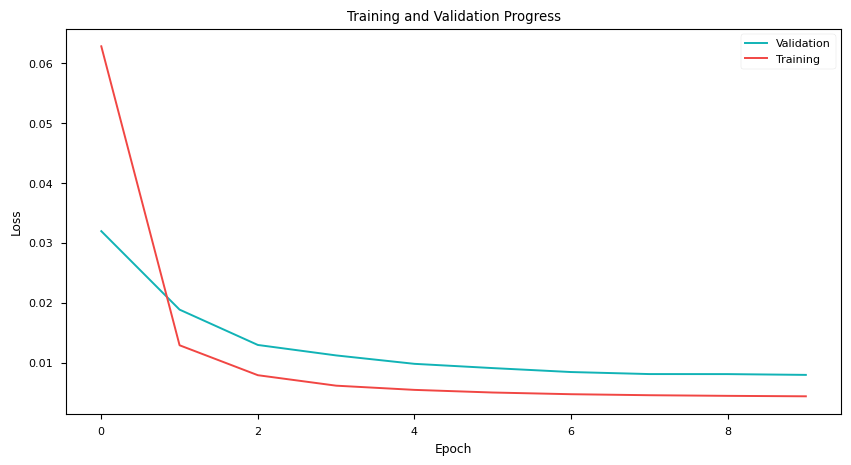

In [69]:
n_epochs = 10
input_dim = 2
out_dim = 3
model = train(train_loader, valid_loader, n_epochs, input_dim, out_dim, verbose=True)

In [63]:
y_true = ts_data[['load']]
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    model, X_train, X_valid, X_test, y_true, lookback, delay, scaler)

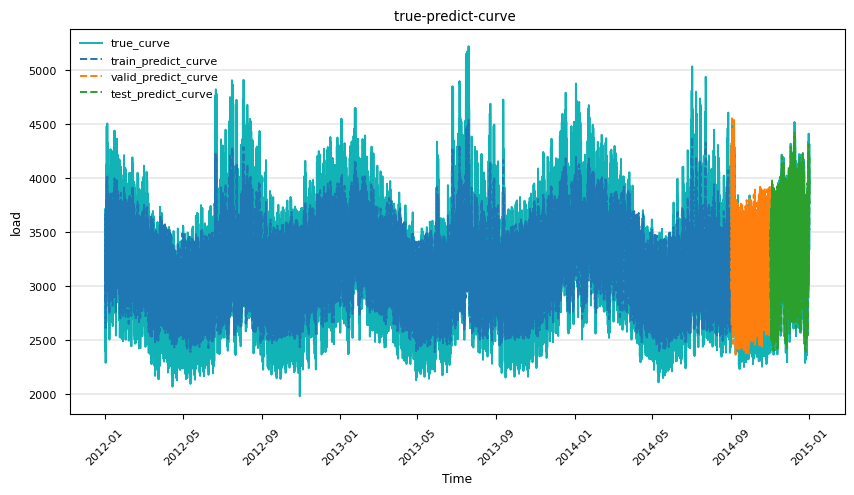

In [64]:
# 静态图
static_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

In [66]:
# #动态图
# dynamic_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

## GRU-torch

### 数据准备

In [157]:
ts_data = pd.read_csv("../data/energy.csv")
ts_data = pd.DataFrame(ts_data[["load", "temp"]].values, index=pd.to_datetime(ts_data["Unnamed: 0"].values), columns=["load", "temp"])
ts_data = ts_data.asfreq(freq='H') #转换为小时频率的数据
ts_data.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [158]:
#多变量数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [159]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据
    for i in range(lookback, len(feature) - delay):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader
    loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

### 模型训练

In [160]:
def train(train_loader, valid_loader, n_epochs, input_dim, out_dim, verbose=True, plots=True):
    #单向GRU
    class GRU(nn.Module):
        def __init__(self):
            super().__init__()
            self.gru = nn.GRU(input_size=1, hidden_size=5, num_layers=1, batch_first=True)
            self.linear = nn.Linear(in_features=5, out_features=1) #delay=1
        def forward(self, x):
            x, _ = self.gru(x)
            x = self.linear(x)
            return x
        
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    #训练模型
    model = GRU().to(device)
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()

    # 损失函数值
    train_losses, val_losses = [], []

    for epoch in range(n_epochs):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch)[:,-1:,:]
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)[:,-1:,:]
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    #绘制损失函数图
    if plots:
        plot_loss(train_losses, val_losses)
    return model

### 模型预测

In [171]:
def predict(model, X_train, X_valid, X_test, y_true, lookback, delay, scaler):
    lookback = lookback - 1 #包含当前时间点
    #数据集长度
    train_size = len(X_train) + lookback + delay
    valid_size = len(X_valid) + lookback + delay
    test_size = len(X_test) + lookback + delay
    
    #时间序列形状
    timeseries_y = y_true.values
    timeseries_x = y_true.index
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        X_train = X_train.to(device) #将数据应用到GPU
        y_pred = model(X_train)
        y_pred = y_pred[:, -1, -1:] #取最后一个输出
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        train_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        train_plot_x = timeseries_x[: train_size]
        '''验证集设置'''
        X_valid = X_valid.to(device)
        y_pred = model(X_valid)
        y_pred = y_pred[:, -1, -1:]
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        valid_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        X_test = X_test.to(device)
        y_pred = model(X_test)
        y_pred = y_pred[:, -1, -1:]
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        test_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, )) + [np.nan]*(delay-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

### 结果分析

In [162]:
#损失函数图
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(val_losses, linestyle='-',color = '#11b3b6')
    plt.plot(train_losses, linestyle='-',color = '#f14643')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Progress")
    plt.legend(["Validation", "Training"])
    plt.show()

In [163]:
# 静态图
def static_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
    #绘图，原始图，训练图，验证图，测试图
    fig = plt.figure(1, (10, 5))
    ax = fig.add_subplot(1,1,1)
    plt.style.use('seaborn-v0_8-paper') #绘制背景色
    plt.grid(axis = 'y',linewidth=0.35) #绘制网格
    plt.title('true-predict-curve ') #图标题
    plt.xticks(rotation = 45) #rotation文字旋转方向
    ax.plot(timeseries_x, timeseries_y, linestyle='-',color = '#11b3b6',label = 'true_curve')
    ax.plot(train_plot_x, train_plot_y, linestyle='--',label = 'train_predict_curve')
    ax.plot(valid_plot_x, valid_plot_y, linestyle='--',label = 'valid_predict_curve')
    ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'test_predict_curve')
    ax.legend(frameon=False) #绘制图例
    plt.xlabel('Time')
    plt.ylabel(y_true.columns.values[0])
    plt.show()

In [164]:
# 动态图
def dynamic_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
    # 准备画布
    fig = go.Figure()

    # 添加实际数据
    fig.add_trace(
        go.Scatter(
            x=timeseries_x,
            y=timeseries_y.reshape(timeseries_y.shape[0], ),
            mode='lines',
            name='true_curve',
            line = dict(color=None, width=2, dash=None)
        ))

    # 添加训练预测数据
    fig.add_trace(
        go.Scatter(
            x=train_plot_x,
            y=train_plot_y,
            mode='lines',
            name='train_predict_curve',
            line = dict(color=None, width=2, dash=None)
        ))

    # 添加验证预测数据
    fig.add_trace(
        go.Scatter(
            x=valid_plot_x,
            y=valid_plot_y,
            mode='lines',
            name='valid_predict_curve',
            line = dict(color=None, width=2, dash=None)
        ))

    # 添加测试预测数据
    fig.add_trace(
        go.Scatter(
            x=test_plot_x,
            y=test_plot_y,
            mode='lines',
            name='test_predict_curve',
            line = dict(color=None, width=2, dash=None)
        ))

    #更新图表的排版
    fig.update_layout(
        title='true-predict-curve',
        xaxis=dict(title="date"),
        yaxis=dict(title="load"),
        width=900,  #图表宽度
        height=500,  #图表长度
        template="simple_white"  #图表风格
    )

    fig.show()

### 单变量单步预测模型

In [165]:
# 构造参数字典
params = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 1) y_train shape: (23376, 1)
x_valid shape: (1464, 1) y_valid shape: (1464, 1)
x_test shape: (1464, 1) y_test shape: (1464, 1)


In [166]:
lookback = 6
delay = 1
batch_size = 32
X_train, y_train, train_loader = create_dataset(x_train, y_train, lookback, delay, batch_size)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, lookback, delay, batch_size)
X_test, y_test, test_loader = create_dataset(x_test, y_test, lookback, delay, batch_size)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23370, 6, 1]),y_size: torch.Size([23370, 1, 1]),loader_len: 731
X_size: torch.Size([1458, 6, 1]),y_size: torch.Size([1458, 1, 1]),loader_len: 46
X_size: torch.Size([1458, 6, 1]),y_size: torch.Size([1458, 1, 1]),loader_len: 46


Epoch [1/10], Training Loss: 0.0952, Validation Loss: 0.0288
Epoch [2/10], Training Loss: 0.0083, Validation Loss: 0.0066
Epoch [3/10], Training Loss: 0.0026, Validation Loss: 0.0037
Epoch [4/10], Training Loss: 0.0018, Validation Loss: 0.0027
Epoch [5/10], Training Loss: 0.0013, Validation Loss: 0.0023
Epoch [6/10], Training Loss: 0.0011, Validation Loss: 0.0021
Epoch [7/10], Training Loss: 0.0010, Validation Loss: 0.0016
Epoch [8/10], Training Loss: 0.0008, Validation Loss: 0.0014
Epoch [9/10], Training Loss: 0.0007, Validation Loss: 0.0012
Epoch [10/10], Training Loss: 0.0006, Validation Loss: 0.0011


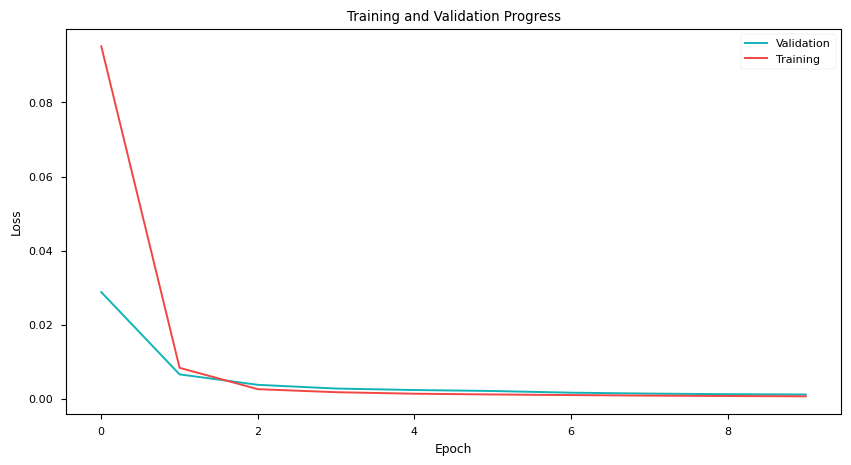

In [167]:
n_epochs = 10
input_dim = 1
out_dim = 1
model = train(train_loader, valid_loader, n_epochs, input_dim, out_dim, verbose=True, plots=True)

In [172]:
y_true = ts_data[['load']]
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    model, X_train, X_valid, X_test, y_true, lookback, delay, scaler)

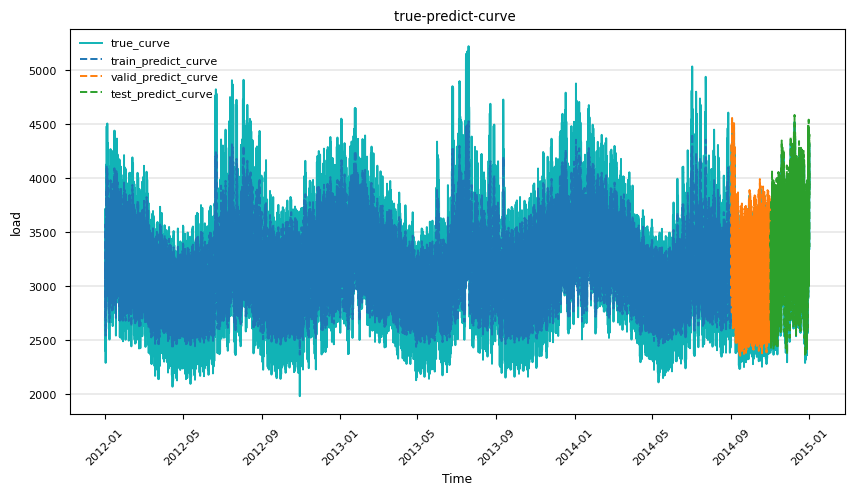

In [173]:
# 静态图
static_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

In [18]:
# #动态图
# dynamic_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

## CNN-torch

### 数据准备

In [174]:
ts_data = pd.read_csv("../data/energy.csv")
ts_data = pd.DataFrame(ts_data[["load", "temp"]].values, index=pd.to_datetime(ts_data["Unnamed: 0"].values), columns=["load", "temp"])
ts_data = ts_data.asfreq(freq='H') #转换为小时频率的数据
ts_data.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [175]:
#多变量数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [176]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据
    for i in range(lookback, len(feature) - delay):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    X, y = X.permute(0,2,1), y.permute(0,2,1)
    #创建dataloader
    loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

### 模型训练

In [177]:
def train(train_loader, valid_loader, n_epochs, input_dim, out_dim, seq_length, verbose=True, plots=True):
    # 定义一维CNN模型
    class CNN(nn.Module):
        def __init__(self, input_dim, output_size, sequence_length, num_layers):
            super(CNN, self).__init__()
            layers = []
            in_channels = input_dim  
            for _ in range(num_layers):
                # 保证输出维度不变，kernel_size=3,padding=1,stride=1
                layers.append(nn.Conv1d(in_channels=in_channels, out_channels=64, kernel_size=3, padding=1)) 
                layers.append(nn.ReLU())
                in_channels = 64 # 调整输入通道数
            self.conv_layers = nn.Sequential(*layers)
            self.fc = nn.Linear(in_features=in_channels * sequence_length, out_features=output_size)

        def forward(self, x):
            x = self.conv_layers(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)
            return x
        
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    # 初始化模型、损失函数和优化器，sequence_length时间步，num_layersCNN层数
    model = CNN(input_dim = input_dim, output_size = out_dim, sequence_length = seq_length, num_layers = 5).to(device)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001) 
    
    # 损失函数值
    train_losses, val_losses = [], []

    for epoch in range(n_epochs):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch)
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    #绘制损失函数图
    if plots:
        plot_loss(train_losses, val_losses)
    return model

### 模型预测

In [178]:
def predict(model, X_train, X_valid, X_test, y_true, lookback, delay, scaler):
    lookback = lookback - 1 #包含当前时间点
    #数据集长度
    train_size = len(X_train) + lookback + delay
    valid_size = len(X_valid) + lookback + delay
    test_size = len(X_test) + lookback + delay
    
    #时间序列形状
    timeseries_y = y_true.values
    timeseries_x = y_true.index
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #关闭自动求导功能
    with torch.no_grad(): 
        '''测试集设置'''
        X_train = X_train.to(device) #将数据应用到GPU
        if delay > 1:
            y_pred = model(X_train)[:,-1:]
        else:
            y_pred = model(X_train)
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        train_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        train_plot_x = timeseries_x[: train_size]
        '''验证集设置'''
        X_valid = X_valid.to(device)
        if delay > 1:
            y_pred = model(X_valid)[:,-1:]
        else:
            y_pred = model(X_valid)
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        valid_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        X_test = X_test.to(device)
        if delay > 1:
            y_pred = model(X_test)[:,-1:]
        else:
            y_pred = model(X_test)
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        test_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, )) + [np.nan]*(delay-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

### 结果分析

In [179]:
#损失函数图
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(val_losses, linestyle='-',color = '#11b3b6')
    plt.plot(train_losses, linestyle='-',color = '#f14643')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Progress")
    plt.legend(["Validation", "Training"])
    plt.show()

In [180]:
# 静态图
def static_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
    #绘图，原始图，训练图，验证图，测试图
    fig = plt.figure(1, (10, 5))
    ax = fig.add_subplot(1,1,1)
    plt.style.use('seaborn-v0_8-paper') #绘制背景色
    plt.grid(axis = 'y',linewidth=0.35) #绘制网格
    plt.title('true-predict-curve ') #图标题
    plt.xticks(rotation = 45) #rotation文字旋转方向
    ax.plot(timeseries_x, timeseries_y, linestyle='-',color = '#11b3b6',label = 'true_curve')
    ax.plot(train_plot_x, train_plot_y, linestyle='--',label = 'train_predict_curve')
    ax.plot(valid_plot_x, valid_plot_y, linestyle='--',label = 'valid_predict_curve')
    ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'test_predict_curve')
    ax.legend(frameon=False) #绘制图例
    plt.xlabel('Time')
    plt.ylabel(y_true.columns.values[0])
    plt.show()

In [181]:
# 动态图
def dynamic_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
    # 准备画布
    fig = go.Figure()

    # 添加实际数据
    fig.add_trace(
        go.Scatter(
            x=timeseries_x,
            y=timeseries_y.reshape(timeseries_y.shape[0], ),
            mode='lines',
            name='true_curve',
            line = dict(color=None, width=2, dash=None)
        ))

    # 添加训练预测数据
    fig.add_trace(
        go.Scatter(
            x=train_plot_x,
            y=train_plot_y,
            mode='lines',
            name='train_predict_curve',
            line = dict(color=None, width=2, dash=None)
        ))

    # 添加验证预测数据
    fig.add_trace(
        go.Scatter(
            x=valid_plot_x,
            y=valid_plot_y,
            mode='lines',
            name='valid_predict_curve',
            line = dict(color=None, width=2, dash=None)
        ))

    # 添加测试预测数据
    fig.add_trace(
        go.Scatter(
            x=test_plot_x,
            y=test_plot_y,
            mode='lines',
            name='test_predict_curve',
            line = dict(color=None, width=2, dash=None)
        ))

    #更新图表的排版
    fig.update_layout(
        title='true-predict-curve',
        xaxis=dict(title="date"),
        yaxis=dict(title="load"),
        width=900,  #图表宽度
        height=500,  #图表长度
        template="simple_white"  #图表风格
    )

    fig.show()

### 单变量单步预测模型

In [182]:
# 构造参数字典
params = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 1) y_train shape: (23376, 1)
x_valid shape: (1464, 1) y_valid shape: (1464, 1)
x_test shape: (1464, 1) y_test shape: (1464, 1)


In [183]:
lookback = 6
delay = 1
batch_size = 32
X_train, y_train, train_loader = create_dataset(x_train, y_train, lookback, delay, batch_size)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, lookback, delay, batch_size)
X_test, y_test, test_loader = create_dataset(x_test, y_test, lookback, delay, batch_size)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23370, 1, 6]),y_size: torch.Size([23370, 1, 1]),loader_len: 731
X_size: torch.Size([1458, 1, 6]),y_size: torch.Size([1458, 1, 1]),loader_len: 46
X_size: torch.Size([1458, 1, 6]),y_size: torch.Size([1458, 1, 1]),loader_len: 46


Epoch [1/10], Training Loss: 0.0326, Validation Loss: 0.0490
Epoch [2/10], Training Loss: 0.0313, Validation Loss: 0.0492
Epoch [3/10], Training Loss: 0.0311, Validation Loss: 0.0497
Epoch [4/10], Training Loss: 0.0311, Validation Loss: 0.0487
Epoch [5/10], Training Loss: 0.0310, Validation Loss: 0.0496
Epoch [6/10], Training Loss: 0.0310, Validation Loss: 0.0485
Epoch [7/10], Training Loss: 0.0310, Validation Loss: 0.0486
Epoch [8/10], Training Loss: 0.0310, Validation Loss: 0.0486
Epoch [9/10], Training Loss: 0.0310, Validation Loss: 0.0488
Epoch [10/10], Training Loss: 0.0310, Validation Loss: 0.0485


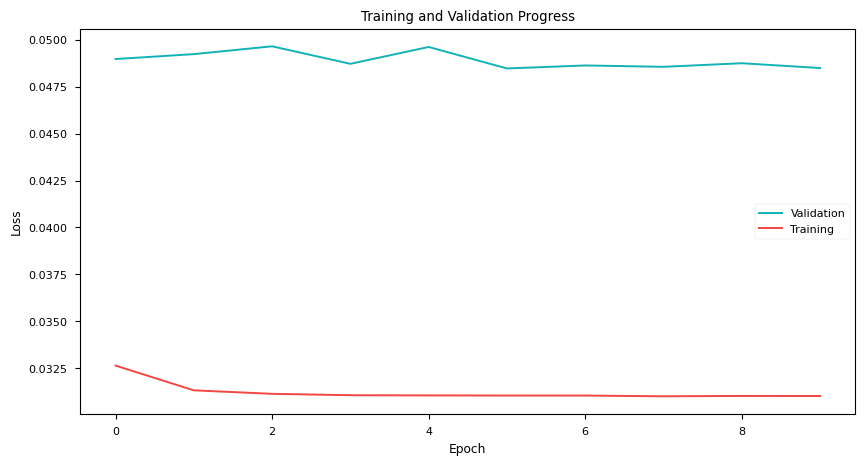

In [184]:
n_epochs = 10
input_dim = 1
out_dim = 1
seq_length = lookback
model = train(train_loader, valid_loader, n_epochs, input_dim, out_dim, seq_length, verbose=True, plots=True)

In [185]:
y_true = ts_data[['load']]
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    model, X_train, X_valid, X_test, y_true, lookback, delay, scaler)

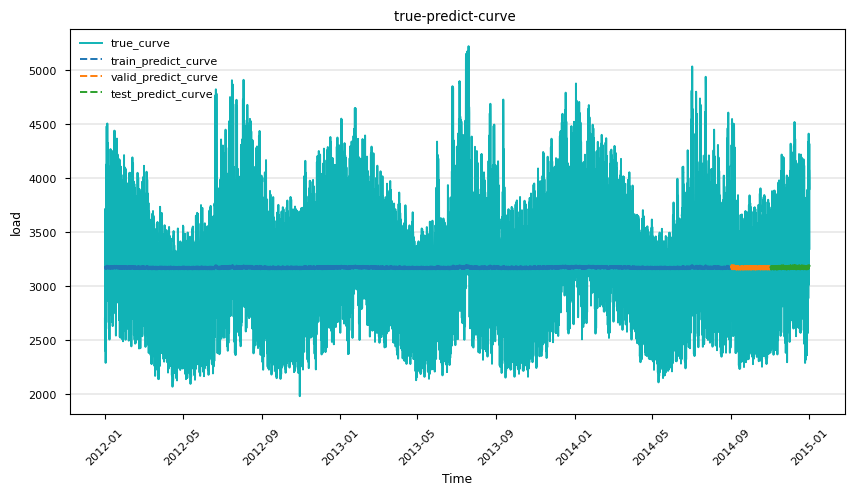

In [186]:
# 静态图
static_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

In [85]:
# #动态图
# dynamic_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

### 单变量多步预测模型

In [135]:
# 构造参数字典
params = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 1) y_train shape: (23376, 1)
x_valid shape: (1464, 1) y_valid shape: (1464, 1)
x_test shape: (1464, 1) y_test shape: (1464, 1)


In [136]:
lookback = 6
delay = 3
batch_size = 32
X_train, y_train, train_loader = create_dataset(x_train, y_train, lookback, delay, batch_size)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, lookback, delay, batch_size)
X_test, y_test, test_loader = create_dataset(x_test, y_test, lookback, delay, batch_size)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 1, 6]),y_size: torch.Size([23368, 1, 3]),loader_len: 731
X_size: torch.Size([1456, 1, 6]),y_size: torch.Size([1456, 1, 3]),loader_len: 46
X_size: torch.Size([1456, 1, 6]),y_size: torch.Size([1456, 1, 3]),loader_len: 46


In [137]:
n_epochs = 10
input_dim = 1
out_dim = 3
seq_length = lookback
model = train(train_loader, valid_loader, n_epochs, input_dim, out_dim, seq_length, verbose=True, plots=False)

Epoch [1/10], Training Loss: 0.0327, Validation Loss: 0.0485
Epoch [2/10], Training Loss: 0.0311, Validation Loss: 0.0489
Epoch [3/10], Training Loss: 0.0310, Validation Loss: 0.0488
Epoch [4/10], Training Loss: 0.0311, Validation Loss: 0.0493
Epoch [5/10], Training Loss: 0.0310, Validation Loss: 0.0490
Epoch [6/10], Training Loss: 0.0311, Validation Loss: 0.0488
Epoch [7/10], Training Loss: 0.0310, Validation Loss: 0.0489
Epoch [8/10], Training Loss: 0.0311, Validation Loss: 0.0485
Epoch [9/10], Training Loss: 0.0310, Validation Loss: 0.0493
Epoch [10/10], Training Loss: 0.0310, Validation Loss: 0.0491


In [138]:
y_true = ts_data[['load']]
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    model, X_train, X_valid, X_test, y_true, lookback, delay, scaler)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

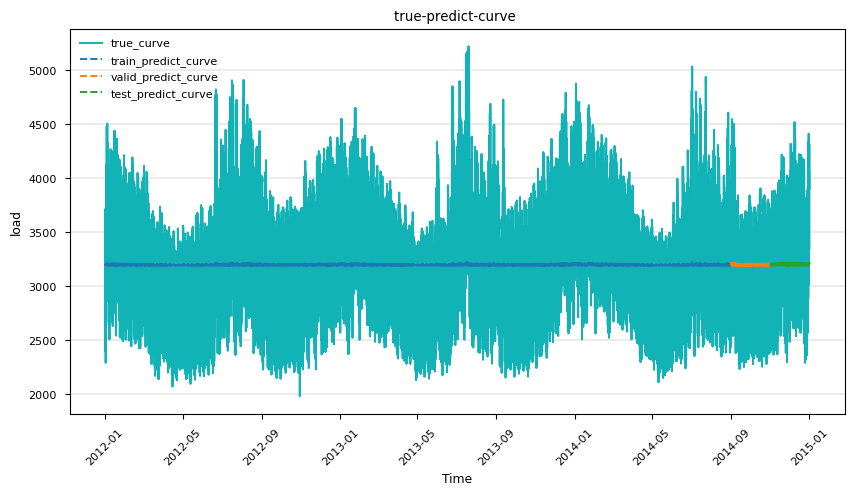

In [129]:
# 静态图
static_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

In [101]:
# #动态图
# dynamic_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

### 多变量多步预测模型

In [132]:
# 构造参数字典
params = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", "temp"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 1)
x_valid shape: (1464, 2) y_valid shape: (1464, 1)
x_test shape: (1464, 2) y_test shape: (1464, 1)


In [133]:
lookback = 6
delay = 3
batch_size = 32
X_train, y_train, train_loader = create_dataset(x_train, y_train, lookback, delay, batch_size)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, lookback, delay, batch_size)
X_test, y_test, test_loader = create_dataset(x_test, y_test, lookback, delay, batch_size)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 2, 6]),y_size: torch.Size([23368, 1, 3]),loader_len: 731
X_size: torch.Size([1456, 2, 6]),y_size: torch.Size([1456, 1, 3]),loader_len: 46
X_size: torch.Size([1456, 2, 6]),y_size: torch.Size([1456, 1, 3]),loader_len: 46


Epoch [1/10], Training Loss: 0.0328, Validation Loss: 0.0504
Epoch [2/10], Training Loss: 0.0311, Validation Loss: 0.0490
Epoch [3/10], Training Loss: 0.0311, Validation Loss: 0.0492
Epoch [4/10], Training Loss: 0.0311, Validation Loss: 0.0489
Epoch [5/10], Training Loss: 0.0311, Validation Loss: 0.0489
Epoch [6/10], Training Loss: 0.0310, Validation Loss: 0.0492
Epoch [7/10], Training Loss: 0.0310, Validation Loss: 0.0487
Epoch [8/10], Training Loss: 0.0311, Validation Loss: 0.0486
Epoch [9/10], Training Loss: 0.0310, Validation Loss: 0.0485
Epoch [10/10], Training Loss: 0.0310, Validation Loss: 0.0486


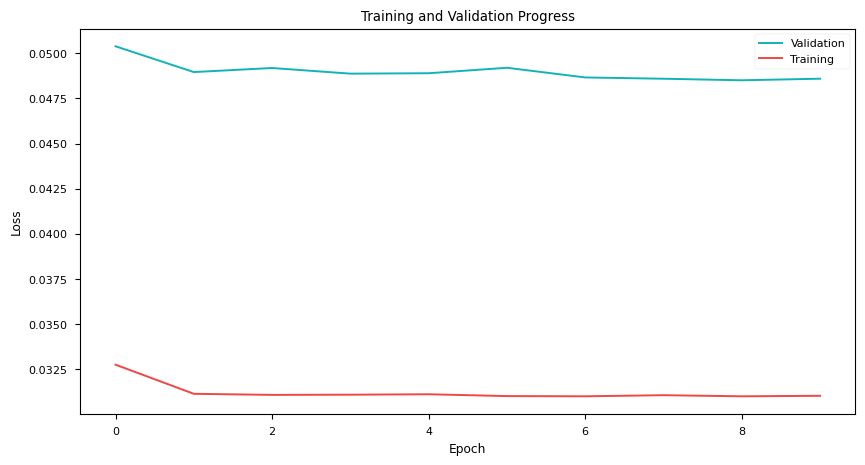

In [134]:
n_epochs = 10
input_dim = 2
out_dim = 3
seq_length = lookback
model = train(train_loader, valid_loader, n_epochs, input_dim, out_dim, seq_length, verbose=True, plots=True)

In [135]:
y_true = ts_data[['load']]
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    model, X_train, X_valid, X_test, y_true, lookback, delay, scaler)

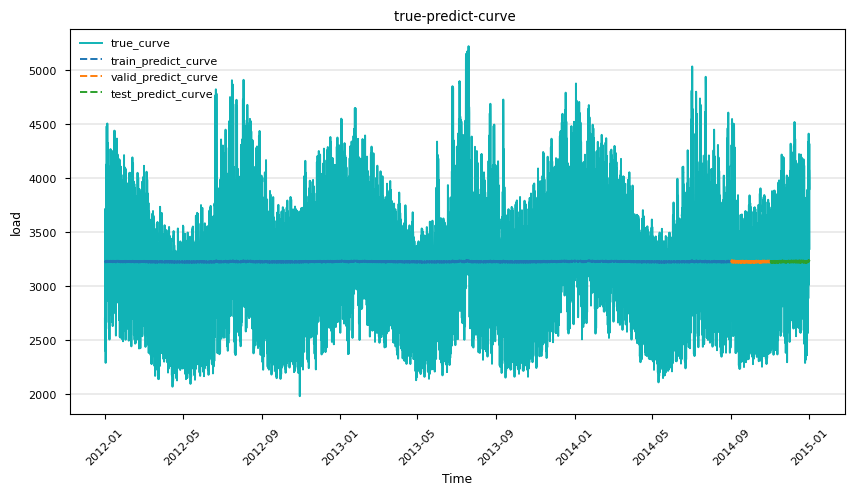

In [136]:
# 静态图
static_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

In [137]:
# #动态图
# dynamic_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

# 时间序列预测的模型部署

## 模型工作流

![hello](../images/p20.jpg)

## 数据流周期

![hello](../images/p21.jpg)

- 数百万已部署的数据仪表不断实时生成功耗数据。
- 收集数据并将其上传到云存储库。
- 在处理原始数据之前，先将其聚合到业务定义的变电站或区域级别。
- 进行特征工程，进而生成模型训练或评价所需的数据，特征集数据存储在数据库中。
- 调用再训练服务以继续训练预测模型，该模型的新版本将保存下来以便Web服务的评价可以再使用。
- 根据适应所需预测频率的计划评价Web服务。
- 预测的数据结果存储在最终用户可访问到的数据库中。
- 客户端检索预测并将其应用回网络中，根据所需用例再进行调用。